## Continuous Bag of Words (CBOW)

Basic implementation of CBOW. Please check [my blog](http://yueyublog.com/posts/continuous-bag-of-words) for details.

In [1]:
import math

import matplotlib.pyplot as plt
import nltk
import numpy as np
import re

from collections import Counter
from sklearn.decomposition import PCA

%matplotlib inline

Load, clean and tokenize the data. Here we use *The Count of Monte Cristo* as the corpus.

In [2]:
with open('data/the_count_of_monte_cristo.txt') as f:
    texts = f.read()

texts = re.sub(r'[,!?;-]', '.', texts)
words = nltk.word_tokenize(texts)
words = [word.lower() for word in words if word.isalpha() or word == '.']

In [3]:
def get_dict(words):
    """
    Converts the given words into a dictionary that maps each word to its index.

    :param words: a list of tokenized words
    :return:      a dictionary mapping each word to its index, containing |V| items
    """
    word2Index = {}
    index = 0
    for word in sorted(list(set(words))):
        word2Index[word] = index
        index += 1
    return word2Index

Functions for generating batches.

In [4]:
def get_context_word_index_with_count(context_words, word2Index):
    """
    Gets the index of each context word and its number of occurrences.

    :param context_words: a list of tokenized context words
    :param word2Index:    a dictionary mapping each word to its index in the vocabulary list
    :return:              pairs of word index and its number of occurrences
    """
    count_dict = Counter(context_words)
    return [(word2Index[word], count_dict[word]) for word in context_words]


def get_context_and_center_word_vectors(words, word2Index, V, C):
    """
    Slides the word window to generate pairs of vectors for the context words and center word.

    :param words:      a list of tokenized words
    :param word2Index: a dictionary mapping each word to its index in the vocabulary list
    :param V:          the size of the vocabulary
    :param C:          half size of the word window
    :return:           pairs of context word vector and center word vector
    """
    j = C
    context_size = 2 * C
    while True:
        context_word = np.zeros(V)
        center_word = np.zeros(V)
        center_word[word2Index[words[j]]] = 1
        context_words = words[(j-C):j] + words[(j+1):(j+C+1)]
        for i, count in get_context_word_index_with_count(context_words, word2Index):
            context_word[i] = count / context_size
        yield context_word, center_word

        # Reset the word window
        if j >= len(words):
            j = 0


def get_batches(words, word2Index, V, C, batch_size):
    """
    Generates batches of context words and center words. Each batch is a pair of two matrices.

    :param words:      a list of tokenized words
    :param word2Index: a dictionary mapping each word to its index in the vocabulary list
    :param V:          size of the vocabulary
    :param C:          half size of the word window
    :param batch_size: the number of word vectors in each batch, typically 2^n
    :return:           pairs of matrices representing the context words and center words respectively. Shape (V, batch_size)
    """
    context_word_batch = []
    center_word_batch = []
    for context_word, center_word in get_context_and_center_word_vectors(words, word2Index, V, C):
        while len(context_word_batch) < batch_size:
            context_word_batch.append(context_word)
            center_word_batch.append(center_word)
        else:
            yield np.array(context_word_batch).T, np.array(center_word_batch).T

In [5]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=0)

Noticing that $\boldsymbol{\mathrm{y}}$ is one hot vector, we only need to consider the bit where the correct word's one
hot vector is $1$.

In [6]:
def compute_cost(Y, Y_hat, batch_size):
    return -1 / batch_size * np.sum(np.log(Y_hat[Y == 1]))

In [7]:
def initialize_params_he(N, V):
    """
    He initialization.
    """
    scaler1 = np.sqrt(2./V)
    scaler2 = np.sqrt(2./N)
    W1 = np.random.randn(N, V) * scaler1
    W2 = np.random.randn(V, N) * scaler2
    b1 = np.zeros((N, 1)) * scaler1
    b2 = np.zeros((V, 1)) * scaler2
    return W1, W2, b1, b2


def forward_prop(X, W1, W2, b1, b2):
    """
    Computes the hidden layer and score.

    :param X:              the averaged vector for the context words. Shape (|V|, batch_size)
    :param W1, W2, b1, b2: parameters to learn
    :return:               Z: score matrix. Shape (|V|, batch_size)
                           H: hidden layer matrix. Shape (N, batch_size)
    """
    H = W1 @ X + b1
    H[H < 0] = 0
    Z = W2 @ H + b2
    return Z, H


def back_prop(X, Y_hat, Y, H, W2):
    """
    Computes the gradients with respect to W1, W2, b1 and b2.

    :param X:     batch of average vectors for the context words. Shape (|V|, batch_size)
    :param Y_hat: the predicted distribution vectors. Shape (|V|, batch_size)
    :param Y:     one hot vectors representing the true values. Shape (|V|, batch_size)
    :param H:     batch of vectors for the hidden layer. Shape (N, batch_size)
    :param W2:    the output word matrix. Shape (|V|, N)
    :return:      grad_W1, grad_W2, grad_b1, grad_b2
    """
    _, batch_size = X.shape

    # Compute the gradient of J_batch with respect to H
    delta1 = W2.T @ (Y_hat - Y)
    delta1[delta1 < 0] = 0

    # Compute the gradients
    grad_W1 = 1 / batch_size * delta1 @ X.T
    grad_W2 = 1 / batch_size * (Y_hat - Y) @ H.T
    grad_b1 = 1 / batch_size * np.sum(delta1, axis=1, keepdims=True)
    grad_b2 = 1 / batch_size * np.sum(Y_hat - Y, axis=1, keepdims=True)

    return grad_W1, grad_W2, grad_b1, grad_b2


def fit(words, word2Index, N, V, C, batch_size=128, alpha=0.1, eps=1e-4, max_iters=5000):
    """
    Computes the parameters using gradient descent.

    :param words:      the source words
    :param word2Index: a dictionary mapping each word to its unique index
    :param N:          the dimension of embedded word
    :param V:          the size of the vocabulary
    :param C:          half size of the word window
    :param batch_size: better set to 2^n
    :param alpha:      the learning rate
    :param eps:        the convergence criteria
    :param max_iters:  the maximum number of iterations allowed
    :return:           W1, W2, b1, b2 and a record of the cost and number of iterations
    """
    W1, W2, b1, b2 = initialize_params_he(N, V)

    iters = 0
    prev_cost = math.inf
    iterations = []
    costs = []

    for X, Y in get_batches(words, word2Index, V, C, batch_size):
        Z, H = forward_prop(X, W1, W2, b1, b2)
        Y_hat = softmax(Z)

        this_cost = compute_cost(Y, Y_hat, batch_size)

        # Check convergence
        if iters == max_iters or prev_cost - this_cost < eps:
            break

        # Track the cost in terms of the number of iterations
        if (iters + 1) % 10 == 0:
            iterations.append(iters)
            costs.append(this_cost)

        prev_cost = this_cost

        # Compute the gradients and update parameters
        grad_W1, grad_W2, grad_b1, grad_b2 = back_prop(X, Y_hat, Y, H, W2)

        W1 = W1 - alpha * grad_W1
        W2 = W2 - alpha * grad_W2
        b1 = b1 - alpha * grad_b1
        b2 = b2 - alpha * grad_b2

        iters += 1

    return W1, W2, b1, b2, iterations, costs

Fit the model.

In [8]:
C = 5
N = 80
word2Index = get_dict(words)
W1, W2, b1, b2, iterations, costs = fit(words, word2Index, N, len(word2Index), C=2)

Plot the cost function.

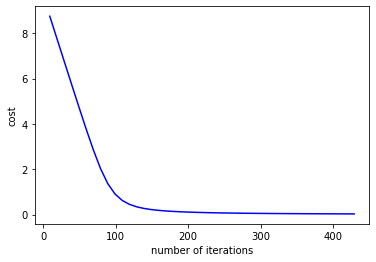

In [9]:
plt.figure()
plt.plot(iterations, costs, 'b')
plt.xlabel('number of iterations')
plt.ylabel('cost')
plt.show()

Finally, let's take a look at the word vectors in 2d.

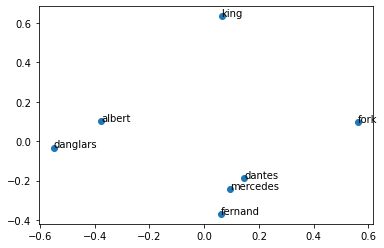

In [17]:
# Get word embeddings
word_embeddings = (W1.T + W2) / 2.0
test_words = ['dantes', 'danglars', 'mercedes', 'albert', 'fernand', 'king', 'fork']
test_indices = [word2Index[word] for word in test_words]
X_test = word_embeddings[test_indices, :]

# Perform PCA
pca = PCA(n_components=2)
result = pca.fit_transform(X_test)

# Scatter plot
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(test_words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

We can see that Dantes, Mercedes and Fernand are grouped together. In addition, Danglars and Albert are close. These
look pretty reasonable, even though the two groups are far from each other. However, because PCA depends on the
particular projection, maybe they are more related in some other dimensions.